# Coarse Graining of Chignolin

In this tutorial, we provide instructions on training and simulating a coarse-grained model of miniprotein - **Chignolin**. We will go through the whole process in a few steps:
1. Data preparation
2. Training
3. Simulation 
4. Analysis

More details and theoretical background is provided in the corresponding publication. 

Let's start with some standard imports.

In [2]:
import os
import numpy as np
import pandas as pd
import yaml
from tqdm import tqdm
from scipy.optimize import curve_fit
from moleculekit.molecule import Molecule
from moleculekit.projections.metricrmsd import MetricRmsd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

First, download and unpack the data.

In [2]:
!wget pub.htmd.org/torchMD_tutorial_data.tar.gz

--2020-10-21 18:14:01--  http://pub.htmd.org/torchMD_tutorial_data.tar.gz
Resolving pub.htmd.org (pub.htmd.org)... 84.89.134.148
Connecting to pub.htmd.org (pub.htmd.org)|84.89.134.148|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41989012 (40M) [application/x-gzip]
Saving to: ‘torchMD_tutorial_data.tar.gz.1’

100%[======================================>] 41,989,012  86.8MB/s   in 0.5s   

2020-10-21 18:14:02 (86.8 MB/s) - ‘torchMD_tutorial_data.tar.gz.1’ saved [41989012/41989012]



In [3]:
!tar -xvf torchMD_tutorial_data.tar.gz

data/
data/chignolin_ca_coords.npy
data/chignolin_ca_forces.npy
data/chignolin_ca_initial_coords.xtc
data/chignolin_cln025.pdb
data/chignolin_priors_fulldata.yaml
data/.chignolin_ca_initial_coords.xtc
data/.chignolin_ca_initial_coords.xtc.numframes
data/sim_fulldata/
data/sim_fulldata/output_0.npy
data/sim_fulldata/output_1.npy
data/sim_fulldata/output_2.npy
data/sim_fulldata/output_3.npy
data/sim_fulldata/output_4.npy
data/sim_fulldata/output_5.npy
data/sim_fulldata/output_6.npy
data/sim_fulldata/output_7.npy
data/sim_fulldata/output_8.npy
data/sim_fulldata/output_9.npy
data/sim_fulldata/monitor_0.csv
data/sim_fulldata/monitor_1.csv
data/sim_fulldata/monitor_2.csv
data/sim_fulldata/monitor_3.csv
data/sim_fulldata/monitor_4.csv
data/sim_fulldata/monitor_5.csv
data/sim_fulldata/monitor_6.csv
data/sim_fulldata/monitor_7.csv
data/sim_fulldata/monitor_8.csv
data/sim_fulldata/monitor_9.csv
data/sim_fulldata/traj_xtc/
data/sim_fulldata/traj_xtc/traj0/
data/sim_fulldata/traj_xtc/traj0/traj.xt

# 1. Data preparation

In this section, we will produce all the files necessary for training and simulation.

## 1.1. PDB to PSF conversion

In this point, we will convert PDB file with full atom Chignolin chain to topology (PSF) file containing a coarse-grained system. For this purpose, we use CLN025 variant of chignolin.

In this example, the coarse-grained system consists only of CA atoms that are connected by "bonds". To build such system we use **pdb2psf_CA** function. Bonded energy term and repulsion will be the only prior terms we use, therefore we don't need to define angles, dihedrals and impropers in PSF file. 

The bead names indicate that it's CA atom and a third letter corresponds to a one-letter abbreviation of the amin oacid, eg. **CAA** for alanine. 

In [4]:
from torchmd_cg.utils.psfwriter import pdb2psf_CA

PDB_file = 'data/chignolin_cln025.pdb'
PSF_file = 'data/chignolin_ca_top.psf'

pdb2psf_CA(PDB_file, PSF_file, bonds = True, angles = False)

2020-10-21 18:14:04,536 - moleculekit.molecule - INFO - Removed 83 atoms. 10 atoms remaining in the molecule.


## 1.2. Prior force parameters extraction form MD data

In this part, we will extract the parameters for prior forces from MD data. 

We will use only the subset of data. However, a forcefield file computed based on full simulation data is provided in **data/chignolin_priors_fulldata.yaml**

The functions defined below correspond to force terms defined in torchMD simulation package. 
* **harminic** to  bonded term (**Bonds**)
* **CG** to repulsive term (**RepulsionCG**)

**Load the data**

Data provided here is a subset of full simulation data for chignolin. It is supposed to act as a simple example of data preparation for this tutorial. 

* data presented here - **18689** frames  

* the original set - **1868861** frames


In [5]:
mol = Molecule('data/chignolin_ca_top.psf')
arr = np.load('data/chignolin_ca_coords.npy')

Include the array with coordinates in `mol` object

In [6]:
mol.coords = np.moveaxis(arr, 0, -1) 

**Initiate Prior dictionary**

The prior dictionary, that will form a force field file, need to be filled with fields: 

* `atomtypes` - stores unique bead names
* `bonds` - parametrers describing bonded interactions. Both parameters will be calculated based on the training data.
    * `req` - equilibrium distance of the bond
    * `k0` - spring constant
* `lj` - parametrers describing Lenard-Jones interactions. 
    * `epsilon` - will be calculated based on the training data.
    * `sigma` - in this case set to 1.0
    
In this example function fitted to data is not a Lenard-Jones potential, but rather a LJ-inspired function described by the equation: 

```V = 4*eps*((sigma/r)**6) + V0```

* `electrostatics` - parametrers describing electrostatic interactinos:
    * `charge` - in this case 
* `masses` - masses of the beads. In here 12, because all beads correspond to carbon atoms

In [7]:
priors = {}
priors['atomtypes'] = list(set(mol.atomtype))
priors['bonds'] = {}
priors['lj'] = {}
priors['electrostatics'] = {at: {'charge': 0.0} for at in priors['atomtypes']}
priors['masses'] = {at: 12.0 for at in priors['atomtypes']}

### 1.2.1 Bonded interactions

First bonded interactions approximated by harmonic function:

```V = k * (x - x0)**2 + V0```

The fit of the function to data should be inspected and if needed the range of histogram adjusted by changing `fit_range`.

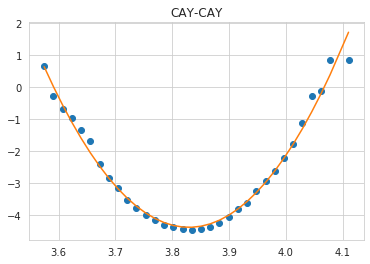

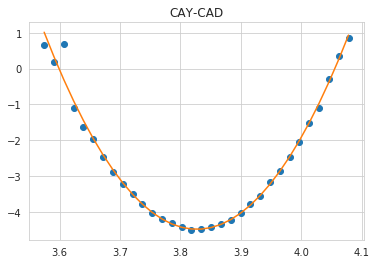

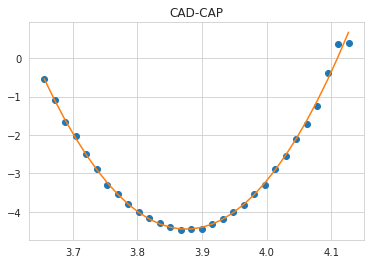

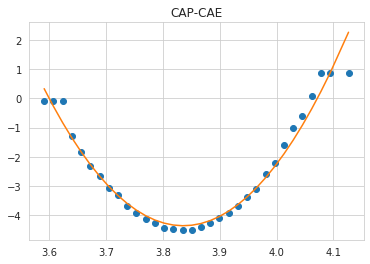

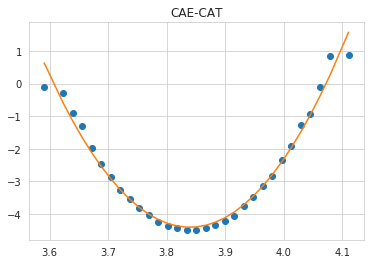

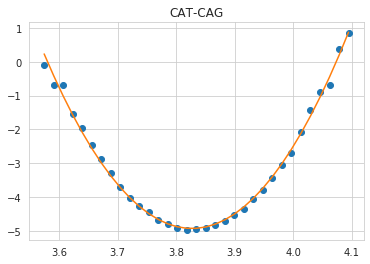

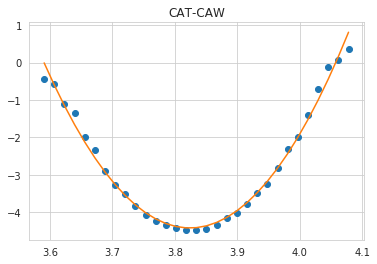

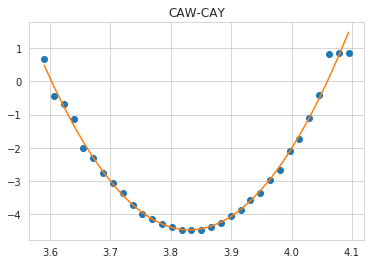

In [8]:
from torchmd_cg.utils.prior_fit import get_param_bonded

T = 350 # K
fit_range = [3.55,4.2]

bond_params = get_param_bonded(mol, fit_range, T)

priors['bonds'] = bond_params

### 1.2.2 Non-bonded interactions

Next non-bonded interactions (interactions between atoms that are not connected by bonds) approximated by a custom function inspired by the repulsive term of Lenard-Jones potential described by the equation: 

```V = 4 * eps * ((sigma/r)**6) + V0```

The fit of the function to data should be inspected and if needed the range of histogram adjusted.

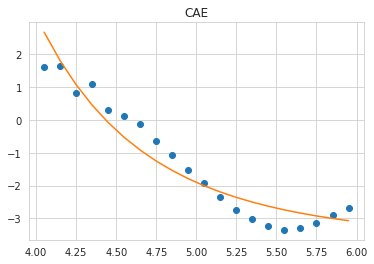

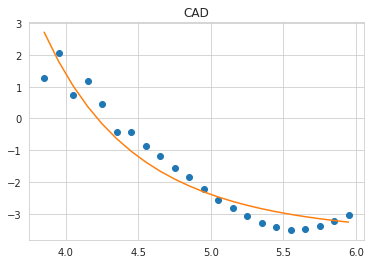

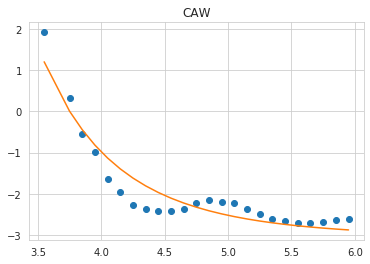

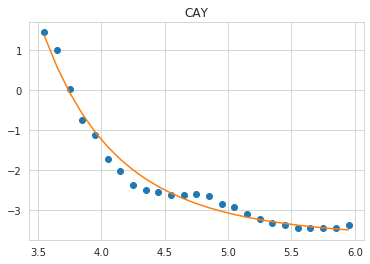

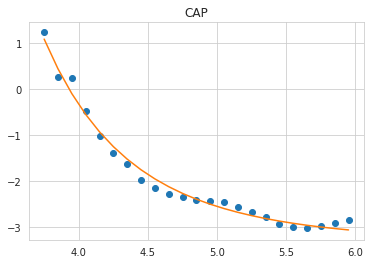

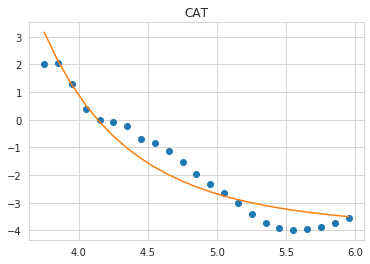

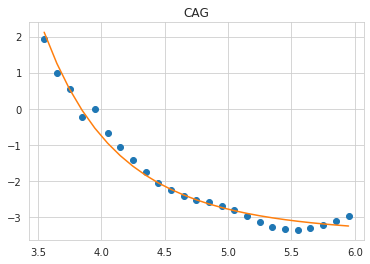

In [9]:
from torchmd_cg.utils.prior_fit import get_param_nonbonded

fit_range = [3, 6]

nonbond_params = get_param_nonbonded(mol, fit_range, T)

priors['lj'] = nonbond_params

Now let's write YAML file with forcefield parameters.

In [11]:
with open("data/chignolin_priors.yaml","w") as f: 
    yaml.dump(priors, f)

## 1.3. Delta-forces Preparation

Now we can use the force field file created in the previous section to extract delta forces that will serve as an input for training. 

To compute delta forces we use **make_deltaforces** function

In [14]:
from torchmd_cg.utils.make_deltaforces import make_deltaforces

coords_npz = 'data/chignolin_ca_coords.npy'
forces_npz = 'data/chignolin_ca_forces.npy'
delta_forces_npz = 'data/chignolin_ca_deltaforces.npy'
forcefield = 'data/chignolin_priors.yaml' 
psf = 'data/chignolin_ca_top.psf'
exclusions = ('bonds')
device = 'cpu' 
forceterms = ['Bonds','RepulsionCG']

make_deltaforces(coords_npz, forces_npz, delta_forces_npz, forcefield, psf, exclusions, device, forceterms)

100%|██████████| 9/9 [00:00<00:00, 1181.49it/s]

Check for broken coords.
No broken frames



/shared/maciej/coarse-graining/torchmd/torchmd/systems.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  atom_pos, dtype=self.pos.dtype, device=self.pos.device
/shared/maciej/coarse-graining/torchmd/torchmd/systems.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  box[r], dtype=self.box.dtype, device=self.box.device
  0%|          | 64/18689 [00:00<00:29, 634.32it/s]

Producing delta forces


100%|██████████| 18689/18689 [00:24<00:00, 747.84it/s]


## 1.4. Embedding Preparation 

Now, let's convert bead names to embeddings, that will be used as an input for training. To each residue assign different number, as listed in a dictionary below.

In [15]:
AA2INT = {'ALA':1,
         'GLY':2,
         'PHE':3,
         'TYR':4,
         'ASP':5,
         'GLU':6,
         'TRP':7,
         'PRO':8,
         'ASN':9,
         'GLN':10,
         'HIS':11,
         'HSD':11,
         'HSE':11,
         'SER':12,
         'THR':13,
         'VAL':14,
         'MET':15,
         'CYS':16,
         'NLE':17,
         'ARG':18,
         'LYS':19,
         'LEU':20,
         'ILE':21
         }

emb = np.array([AA2INT[x] for x in mol.resname], dtype='<U3')
np.save('data/chignolin_ca_embeddings.npy', emb)

# 2. Training

In the next step, we use coordinates and delta-forces to train the network. 

SchNet architecture, applied here, learns the features using continuous filter convolutions on a graph neural network and predicts the forces and energy of the system. 

A set of parameters in the configuration file `train.yaml` is listed here:

```yaml
        coords: "data/chignolin_ca_coords.npy"
        forces: "data/chignolin_ca_deltaforces.npy"
        embeddings: "data/chignolin_ca_embeddings.npy"
        log_dir: train_light
        num_epochs: 200
        batch_size: 1024
        lr: 0.0001
        lr_patience: 4
        lr_min: 1.e-06
        lr_factor: 0.8
        distributed_backend: dp
        gpus: 4
        num_nodes: 1
        num_workers: 8
        seed: 1
        eval_interval: 1
        save_interval: 1
        progress: True
        val_ratio: 0.05
        test_ratio: 0.1
        num_filters: 128
        num_gaussians: 150
        num_interactions: 3
        max_z: 100
        cutoff: 9
```

Now we will go through options in a configuration file:

* training input files locations are defined in parameteres: `coords`, `forces` and `embeddings`
* `log_dir` - output folder
* `lr` - initial value of learning rate 
* `num_epochs` - number of epochs run during the training
* `batch_size` - batch size
* `lr` - initial value of learning rate. The learning rate is optimized with `torch.optim.lr_scheduler.ReduceLROnPlateau` scheduler with parameters: `lr_patience`, `lr_min` and `lr_factor`
* `distributed_backend` - specifies distributed_backend pytorch-ligtning. Here `dp` (Data Parallel) is adjusted for training on multiple-gpus (`gpus`) and 1 machine (`num_nodes`). Other options include:
    * Data Parallel (`distributed_backend='dp'`)(multiple-gpus, 1 machine)
    * DistributedDataParallel (`distributed_backend=’ddp’`) (multiple-gpus across many machines (python script based)).
    * DistributedDataParallel (`distributed_backend=’ddp_spawn’`) (multiple-gpus across many machines (spawn based)).
    * DistributedDataParallel 2 (`distributed_backend=’ddp2’`) (DP in a machine, DDP across machines).
    * Horovod (`distributed_backend=’horovod’`) (multi-machine, multi-gpu, configured at runtime)
* `gpus` - number of GPUs used in training. Specified as a number of required units (eg. `4`) or a list of cuda devices (eg. `[0, 2, 3]')
* `num_nodes` - number of machines used
* `num_workers` - number of workers in data loader
* `seed` for the calculation
* `eval_interval` - evaluation interval
* `save_interval` - saving interval
* `progress` - Progress bar during batching
* `val_ratio` - Percentual of validation set
* `test_ratio` - Percentual of test set
* Finally schnet-specific parameters: 
    * `num_filters`
    * `num_gaussians`
    * `num_interactions`
    * `max_z`
    * `cutoff`

Training is done using python script and can be run by a simple command:

```bash
        mkdir train_light
        python $PATH/torchmd-cg/scripts/light_train.py -c train.yaml 
```
where `$PATH` is a payth to your `torchmd-cg` repo.

The training saves 8 best epochs. The progress of the training is saved in TensorBoard session. The training and validation curves for the training of full Chignolin dataset are presented here:

Text(0, 0.5, 'learning rate')

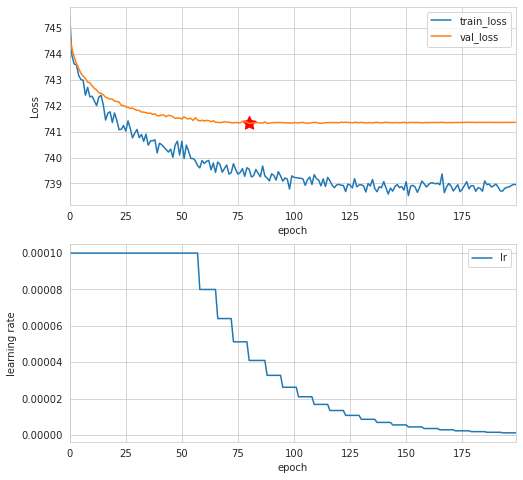

In [7]:
df = pd.read_csv('data/train_out_data.csv')

fig, ax = plt.subplots(nrows = 2, figsize = [8,8])
df.plot(x = 'epoch', y = ['train_loss', 'val_loss'], ax = ax[0])
ax[0].scatter([80], [df['val_loss'].loc[80]], s=200, c='r', marker=(5, 1), label='selected epoch')
ax[0].set_ylabel('Loss')
df.plot(x = 'epoch', y = 'lr', ax = ax[1])
ax[1].set_ylabel('learning rate')

# 3. Simulation 

In this section, we will use the network created in the previous point to simulate the coarse-grained system with Chignoline. Forces acting on beads have two components:

1. Prior forces, determined by parameters extracted in print `1.2` of this tutorial, defined by `data/chignolin_priors.yaml` file. The prior forces applied to the system have to correspond to prior forces defined in point `1.3` to compute delta-forces, in our case:
* Bonds
* RepulsionCG
2. Network that trained and selected in the previous section. The correct epoch has to be selected manually based on validation loss. For the purpose of this tutorial we include one model trained on full dataset of chignoline `data/epoch=80.ckp`. The network is introduced to torchMD as external force with the use of calculator `torchmd_cg.nnp.calculators.torchmdcalc` provided in `torchmd-cg` github repository. The external force calculator class has to have `calculate` method that returns a tuple with energy and force tensors.

The input file `simulate.yaml` for the simulation has a series of parameters:

```yaml
        device: cuda:0
        log_dir: sim_80ep_350K
        output: output
        topology: data/chignolin_ca_top.psf
        coordinates: data/chignolin_ca_initial_coords.xtc
        replicas: 10
        forcefield: data/chignolin_priors_fulldata.yaml
        forceterms:
        - Bonds
        - RepulsionCG
        external:
          module: torchmd_cg.nnp.calculators.torchmdcalc
          embeddings: [ 4,  4,  5,  8,  6, 13,  2, 13,  7,  4]
          file: data/train_fulldata/epoch=80.ckpt
        langevin_gamma: 1
        langevin_temperature: 350
        temperature: 350
        precision: double
        seed: 1
        output_period: 1000
        save_period: 1000
        steps: 10000000
        timestep: 1
```

It can be run as torchMD script:

```bash
        python $PATH/torchmd/run.py --conf simulate.yaml
```

where `$PATH` is a path to your `torchmd` repo (not `torchmd-cg` like point `3.`)

Now we will go through options in a configuration file:

* First we define `device` and the directory `log_dir` and name of the output files `output`.
* in fields `topology` and `coordinates` we define a file with the topology of simulated system in PSF format and XTC file with initial coordinates for the simulation. In here `data/chignolin_ca_initial_coords.xtc` contains 10 frames with initial conformations for chignolin, 5 represent folded state and 5 unfolded. Therefore number of `replicas` is set to 10. 
* `forcefield` defines a file with a forcefield and `forceterms` defines force terms used in the simulation. In our case, these are the prior forces and both forcefield and forceterms have to correspond selection made in point `1.3`.
* `external` defines parameters for an external force acting on the system, in here, neural network: its location `file`, calculator with appropriate class `module` and `embeddings` that will be used as an input for the network and technically have to correspond to a set of embeddings used in the training. However in case of a general network, transferable across the systems the embeddings do not have to overlap.
* `langevin_gamma` and `langevin_gamma` define parameters of the thermostat
* `temperature` defines the initial temperature of the system, that influences the initial velocities of the atoms.
* `precision` double or single
* `seed` for the calculation
* And finally a set of parameters defining the length of the simulation. `timestep` in fs here is defined as 1fs, however, in case of stable systems the step can be as high as 10fs. `steps` define the length of the simulation, in here it will be 10 000 000 * 1 fs = 10 ns in total. `output_period` indicates that the progress of the simulation and trajectory will be saved every 1 000 steps (1ps) and `save_period` indicates that the output files will be updated every 1 000 steps. 

# 4. Analysis

The last step is the analysis of the simulation. Here we will present a simple analysis of the energy and RMSD across the simulation. You can use the results of your simulation, however, for the purpose of this tutorial we include results of 10 ns simulation already performed and stored in `data/sim_fulldata/`.

Plotting energy is quite trivial and for that, we use build-in plotting of pandas DataFrame

Then the RMSD is computed using `MetricRmsd` projection from `moleculekit`, using `data/chignolin_cln025.pdb` file as a reference structure (the same file used to create topology file, as well as extract coordinates of the folded chain). Because torchMD saves the trajectory as `numpy` array we need to first read a topology into `Molecule` object and then replace `coord` array with numpy array loaded from a file:

```python
        mol = Molecule('data/chignolin_ca_top.psf')
        arr = np.load(f'{out_dir}/output_{n}.npy')
        mol.coords = arr.astype(np.float32)
```
Then the resylts are plotted.

You can also save the trajectory as XTC file or other formats that is friendly for molecular visualization softwares:
```python 
        os.makedirs(f'{out_dir}/traj_xtc/traj{n}/', exist_ok=True)
        mol.write(f'{out_dir}/traj_xtc/traj{n}/traj.xtc')
```

It's worth pointing out that both the network and prior energy terms work only on distances of CA atoms, so the model does not learn chirality. Therefore it's also important to analyse the mirror image of the trajectory. In order to do that, you have to multiply coordinates of each atom by a vector `[1, 1, -1]` and repeat the alignment and RMSD calculation.

```python 
        mul = np.ones_like(arr)
        mul[:,2,:] = -1
        arr *= mul
```

2020-10-22 12:03:58,802 - moleculekit.molecule - INFO - Removed 83 atoms. 10 atoms remaining in the molecule.
/shared/maciej/miniconda3/envs/torchmd/lib/python3.7/site-packages/moleculekit/align.py:16: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, A), array(float32, 2d, A))
  covariance = np.dot(P.T, Q)
/shared/maciej/miniconda3/envs/torchmd/lib/python3.7/site-packages/moleculekit/align.py:54: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float32, 2d, A), array(float32, 2d, A))
  all1 = np.dot(all1, rot.T)
2020-10-22 12:04:07,780 - moleculekit.molecule - INFO - Removed 83 atoms. 10 atoms remaining in the molecule.
2020-10-22 12:04:08,582 - moleculekit.molecule - INFO - Removed 83 atoms. 10 atoms remaining in the molecule.
2020-10-22 12:04:09,233 - moleculekit.molecule - INFO - Removed 83 atoms. 10 atoms remaining in the molecule.
2020-10-22 12:04:09,866 - moleculekit.molecule - INFO - Removed 83 atom

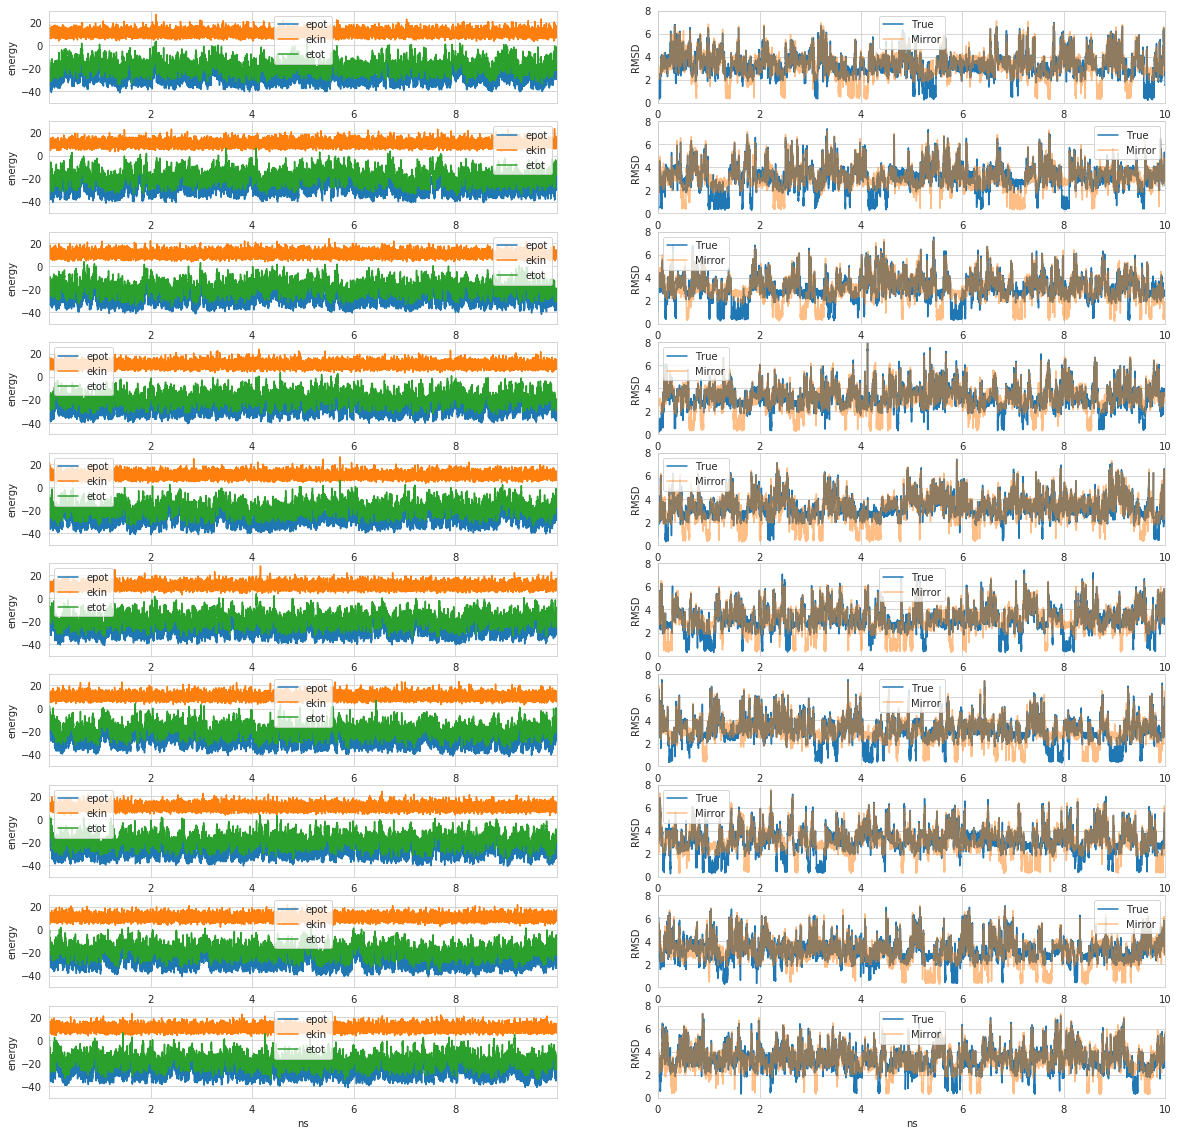

In [8]:
out_dir = 'data/sim_fulldata/'
ts = 0.001 # time step in ns 
n_traj = 10 # number of trajectories

fig, ax = plt.subplots(nrows = n_traj, ncols = 2, figsize=[20,2*n_traj])

for n, axi in enumerate(ax):

    # first plot the energy from monitor file
    
    df = pd.read_csv(f'{out_dir}/monitor_{n}.csv')
    df.plot(x='ns', y=['epot', 'ekin', 'etot'], ax =axi[0])
    axi[0].set_ylabel('energy')
    axi[0].legend()
    axi[0].set_ylim([-50, 30])

    # now plot the RMSD to refernece molecule 
    
    # load a reference from data/chignolin_cln025.pdb file and filter only CA atoms
    mol_ref = Molecule('data/chignolin_cln025.pdb')
    mol_ref.filter('name CA')
    
    # load an array with trajectory and replace the coord array in molecule object
    mol = Molecule('data/chignolin_ca_top.psf')
    arr = np.load(f'{out_dir}/output_{n}.npy')
    mol.coords = arr.astype(np.float32)
    
    # align trajectory (mol) to the reference (mol_ref)
    mol.align('name CA', refmol=mol_ref)
    
    # compute RMSD with MetricRmsd
    rmsd_proj = MetricRmsd(mol_ref, 'name CA', centerstr='name CA', pbc=False)
    rmsd = rmsd_proj.project(mol)
    
    # plot the result
    axi[1].plot(np.arange(len(rmsd))*ts, rmsd, label='True')
    
    # optionally you can also save XTC format to view the trajectory in molecular visualization software
    os.makedirs(f'{out_dir}/traj_xtc/traj{n}/', exist_ok=True)
    mol.write(f'{out_dir}/traj_xtc/traj{n}/traj.xtc')
    
    # repeat the process for mirror image of the molecule.
    mul = np.ones_like(arr)
    mul[:,2,:] = -1
    arr *= mul
    
    # replace the coordinates in mol object
    mol.coords = (arr).astype(np.float32)
    
    # align
    mol.align('name CA', refmol=mol_ref)
    
    # compute RMSD
    rmsd_proj = MetricRmsd(mol_ref, 'name CA', centerstr='name CA', pbc=False)
    rmsd = rmsd_proj.project(mol)
    
    # plot
    axi[1].plot(np.arange(len(rmsd))*ts, rmsd, label = 'Mirror', alpha=0.5)
    axi[1].set_ylim([0,8])
    axi[1].set_xlim([0,10])
    axi[1].set_xlabel('ns')
    axi[1].set_ylabel('RMSD')
    axi[1].legend()
    
plt.show()